In [1]:
import numpy as np
import pandas as pd
import pickle

from collections import defaultdict

import sklearn.metrics
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 16})

In [2]:
data_dir = '/s/project/mll/sergey/effect_prediction/MLM/'

In [3]:
#3'UTR table

utr_table = pd.read_csv(data_dir + 'UTR_coords/GRCh38_3_prime_UTR_clean-sorted.bed', sep='\t',
                       header = None, names=['seq_start','seq_end','seq_name','strand'], usecols=[1,2,3,5])

In [4]:
utr_variants = pd.read_csv(data_dir + 'clinvar/clinvar.3utr.tsv', sep='\t', names=['chrom','pos','var_id','ref','alt','seq_name','label','Phylop100','PhyloP241'])

In [5]:
is_snp = (utr_variants.ref.apply(len)==1) & (utr_variants.alt.apply(len)==1)

utr_variants['vartype'] = is_snp.map({True:'SNP',False:'INDEL'})

In [6]:
utr_variants['varlen'] = abs(utr_variants.ref.apply(len) - utr_variants.alt.apply(len))

In [7]:
utr_variants = utr_variants[utr_variants.label.isin(('Pathogenic','Benign'))]

In [8]:
utr_variants.label = utr_variants.label.apply(lambda x: 1 if 'athogenic' in x else 0)

In [9]:
utr_variants = utr_variants[~utr_variants.seq_name.str.contains(',')]

In [10]:
utr_variants = utr_variants.merge(utr_table, how='left')

In [11]:
#embeddings for intact 3'UTR sequences

with open(data_dir + 'species_aware_emb/all_3utr.pickle', 'rb') as f:
            embeddings = pickle.load(f)
            seqs =  pickle.load(f)
            
utr3_emb = {seq_name.split(':')[0]:embeddings[idx] for idx,seq_name in enumerate(seqs)}

In [12]:
#embeddings for alternative sequences

with open(data_dir + 'clinvar/species_aware_emb/clinvar.pickle', 'rb') as f:
            embeddings = pickle.load(f)
            seqs =  pickle.load(f)
            
clinvar_emb = {seq_name.split(':')[0]:embeddings[idx] for idx,seq_name in enumerate(seqs)}

In [13]:
from numpy.linalg import norm

def cosine(x,y):
    '''
    Compute cosine similarity btw 2 vectors
    '''
    if x is None or y is None:
        return None
    return  -np.dot(x,y)/(norm(x)*norm(y))

In [14]:
utr_variants['y_pred'] = utr_variants.apply(lambda x: 
                                            cosine(utr3_emb.get(x.seq_name, None),
                                                   clinvar_emb.get(f'ClinvarID_{x.var_id}', None)),axis=1)

In [15]:
utr_variants = utr_variants[~utr_variants.y_pred.isna()]

In [23]:
utr_variants.groupby(['vartype']).label.value_counts()

vartype  label
INDEL    0         1076
         1          175
SNP      0        10989
         1          105
Name: count, dtype: int64

In [16]:
sklearn.metrics.roc_auc_score(utr_variants.label, utr_variants.y_pred)

0.5419233615534901

In [17]:
res = []

for seq1 in np.random.choice(list(utr3_emb.keys()),100):
    for seq2 in np.random.choice(list(utr3_emb.keys()),100):
        res.append(cosine(utr3_emb[seq1],utr3_emb[seq2]))

Text(0, 0.5, 'counts')

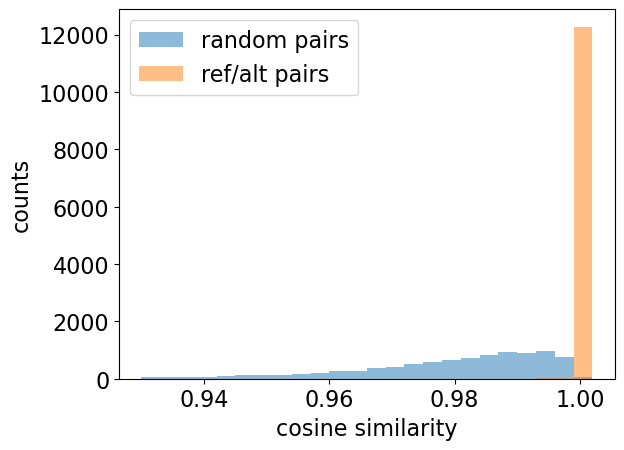

In [18]:
fig, ax = plt.subplots()

ax.hist(-np.array(res), bins=np.arange(0.93,1.003,0.003), alpha=0.5, label = 'random pairs');
ax.hist(-utr_variants.y_pred, bins=np.arange(0.93,1.003,0.003), alpha=0.5, label='ref/alt pairs');
ax.legend(loc='upper left')
ax.set_xlabel('cosine similarity')
ax.set_ylabel('counts')

PR AUC SNP: 0.0091
PR AUC INDEL: 0.41
ROC AUC SNP: 0.5
ROC AUC INDEL: 0.61


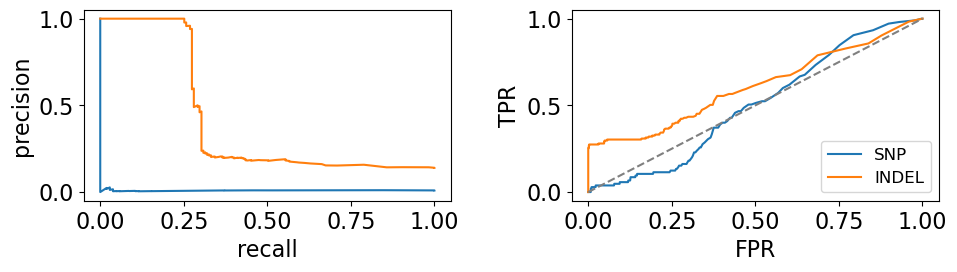

In [23]:

fig, axes = plt.subplots(1,2, figsize=(10,3))

ax = axes[0]

for vartype in ('SNP','INDEL'):
    precision, recall, prc_thr = sklearn.metrics.precision_recall_curve(utr_variants[utr_variants.vartype==vartype].label, 
                                                                        utr_variants[utr_variants.vartype==vartype].y_pred)
    ax.plot(recall,precision, label=vartype)
    print(f'PR AUC {vartype}: {sklearn.metrics.auc(recall,precision):.2}')

ax.set_xlabel('recall')
ax.set_ylabel('precision')

ax = axes[1]

for vartype in ('SNP','INDEL'):
    fpr, tpr, roc_thr = sklearn.metrics.roc_curve(utr_variants[utr_variants.vartype==vartype].label, 
                                                  utr_variants[utr_variants.vartype==vartype].y_pred)
    ax.plot(fpr,tpr, label=vartype)
    print(f'ROC AUC {vartype}: {sklearn.metrics.auc(fpr,tpr):.2}')

ax.plot(fpr,fpr, '--',c='gray')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend(fontsize=12, loc='lower right')

fig.tight_layout()

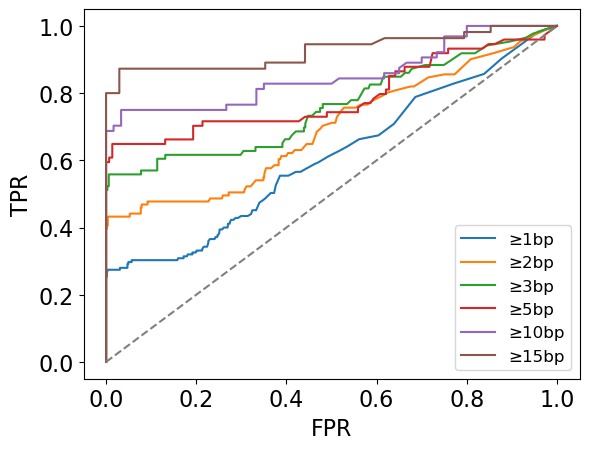

In [33]:
fig, ax = plt.subplots()

res = []

for min_len in (1,2,3,5,10,15):
    df = utr_variants[utr_variants.varlen>=min_len]
    fpr, tpr, _ = sklearn.metrics.roc_curve(df.label, df.y_pred)
    res.append((f'≥{min_len}',len(df),f'{sklearn.metrics.auc(fpr,tpr):.2}'))
    ax.plot(fpr,tpr, label=f'≥{min_len}bp')

ax.plot(fpr,fpr, '--',c='gray')

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend(fontsize=12, loc='lower right')

In [25]:
pd.DataFrame(res, columns=['INDEL length', 'N variants', 'ROC AUC'])

,INDEL length,N variants,ROC AUC
0,≥1,1251,0.61
1,≥2,644,0.69
2,≥3,421,0.76
3,≥5,219,0.79
4,≥10,124,0.85
5,≥15,89,0.93
